### Phase1: Collecting Required Pacakages and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("C:/Users/Mohan/Documents/___.__/Project/EURINR.csv")

### Phase2: Preprocessing

In [3]:
df.head()

,Date,Close
0,01/01/2002 23:58:00,50.20400
1,02/01/2002 23:58:00,43.60000
2,03/01/2002 23:58:00,43.20000
3,04/01/2002 23:58:00,43.13900
4,05/01/2002 23:58:00,43.09701


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7715 entries, 0 to 7714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7715 non-null   object 
 1   Close   7715 non-null   float64
dtypes: float64(1), object(1)
memory usage: 120.7+ KB
None


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)

C:\Users\Mohan\AppData\Local\Temp\ipykernel_3928\303604782.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(df['Date'], inplace=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7715 entries, 2002-01-01 23:58:00 to 2023-12-31 23:58:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7715 non-null   datetime64[ns]
 1   Close   7715 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 180.8 KB


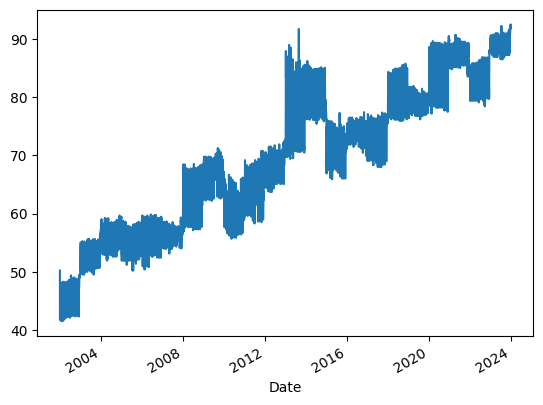

In [7]:
data=df[['Close']]
df['Close'].plot(y='Close')
plt.show()

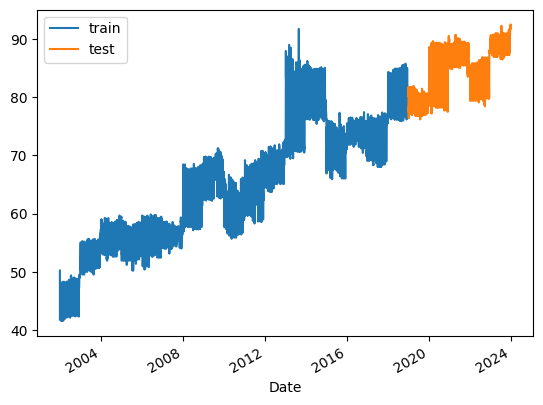

In [8]:
split_date = pd.Timestamp('2019-01-01 23:58:00')

test = data.loc[split_date:]
train = data.loc[:split_date]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)
#train_sc=np.log(train)
#test_sc=np.log(test)

In [10]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

### Phase3: LSTM layer

In [11]:
look_back = 10
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))  # Hyperparameter: Number of LSTM units
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=100, batch_size=32)



Epoch 1/100

185/185 [==============================] - 5s 3ms/step - loss: 0.0501
Epoch 2/100
185/185 [==============================] - 1s 3ms/step - loss: 6.5491e-04
Epoch 3/100
185/185 [==============================] - 1s 3ms/step - loss: 3.6297e-04
Epoch 4/100
185/185 [==============================] - 1s 3ms/step - loss: 2.9297e-04
Epoch 5/100
185/185 [==============================] - 1s 3ms/step - loss: 2.3221e-04
Epoch 6/100
185/185 [==============================] - 1s 3ms/step - loss: 1.8298e-04
Epoch 7/100
185/185 [==============================] - 1s 3ms/step - loss: 1.4821e-04
Epoch 8/100
185/185 [==============================] - 1s 3ms/step - loss: 1.2694e-04
Epoch 9/100
185/185 [==============================] - 1s 3ms/step - loss: 1.2128e-04
Epoch 10/100
185/185 [==============================] - 1s 3ms/step - loss: 1.1596e-04
Epoch 11/100
185/185 [==============================] - 1s 3ms/step - loss: 1.1472e-04
Epoch 12/100
185/185 [==============================]

In [12]:
lstm_predictions = model.predict(X_test)

58/58 [==============================] - 1s 2ms/step


In [13]:
residuals = X_test - lstm_predictions

In [14]:
residuals.ravel()

array([0.00925068, 0.0089684 , 0.00913894, ..., 0.01466098, 0.01458735,
       0.01477195])

In [15]:
residuals= pd.DataFrame(residuals, columns=['Y'])
for s in range(1,2):
    residuals['X_{}'.format(s)] = residuals['Y'].shift(s)
    
residuals_x = residuals.dropna().drop('Y', axis=1)
residuals_y = residuals.dropna().drop('X_1', axis=1)

In [16]:
residuals_x.shape,residuals_y.shape

((1824, 1), (1824, 1))

### Phase4: RF layer

In [17]:
rf_regressor = RandomForestRegressor(random_state=42,max_depth=10,max_features='sqrt',min_samples_leaf = 1,min_samples_split = 5,n_estimators=100)

In [18]:
rf_regressor.fit(residuals_x, residuals_y)

c:\Users\Mohan\anaconda3\envs\base_2\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=5,
                      random_state=42)

In [19]:
rf_predictions = rf_regressor.predict(residuals_x)

In [20]:
rf_predictions=rf_predictions.reshape(-1,1)

In [21]:
lstm_predictions.shape,rf_predictions.shape

((1825, 1), (1824, 1))

In [22]:
final_predictions = lstm_predictions[1:] + rf_predictions

In [23]:
final_predictions.shape,y_test.shape

((1824, 1), (1825, 1))

In [24]:
test_mse = mean_squared_error(y_test[1:], final_predictions)
print('Test MSE:', test_mse)

Test MSE: 5.2396401407222915e-05


In [25]:
y_test.shape,final_predictions.shape

((1825, 1), (1824, 1))

### Phase5: Result and Conclusion

In [26]:
mae_lstm = mean_absolute_error(lstm_predictions,y_test)
mae_RF =mean_absolute_error(rf_predictions, y_test[1:])
mae_hybrid =mean_absolute_error(final_predictions,y_test[1:])
mse_lstm = mean_squared_error(lstm_predictions,y_test)
mse_RF =mean_squared_error(rf_predictions, y_test[1:])
mse_hybrid =mean_squared_error(final_predictions,y_test[1:])
rmse_lstm = np.sqrt(mean_squared_error(lstm_predictions,y_test))
rmse_RF =np.sqrt(mean_squared_error(rf_predictions, y_test[1:]))
rmse_hybrid =np.sqrt(mean_squared_error(final_predictions,y_test[1:]))
r2_lstm = r2_score(lstm_predictions,y_test)
r2_RF =r2_score(rf_predictions, y_test[1:])
r2_hybrid =r2_score(final_predictions,y_test[1:])

Mean Absolute Error (LSTM)  : 0.011716593206556816
Mean Absolute Error (RF)    : 0.8459791858515099
Mean Absolute Error (Hybrid): 0.004702224505258668

Mean Squared Error (LSTM)  : 0.00017840938621295312
Mean Squared Error (RF)    : 0.7225787005583441
Mean Squared Error (Hybrid): 5.2396401407222915e-05

Root Mean Squared Error (LSTM)  : 0.013356997649657393
Root Mean Squared Error (RF)    : 0.8500462931854618
Root Mean Squared Error (Hybrid): 0.007238535860740272

r2_score (LSTM)  : 0.9741086988996914
r2_score (RF)    : -256142.6797529412
r2_score (Hybrid): 0.9926915071116434


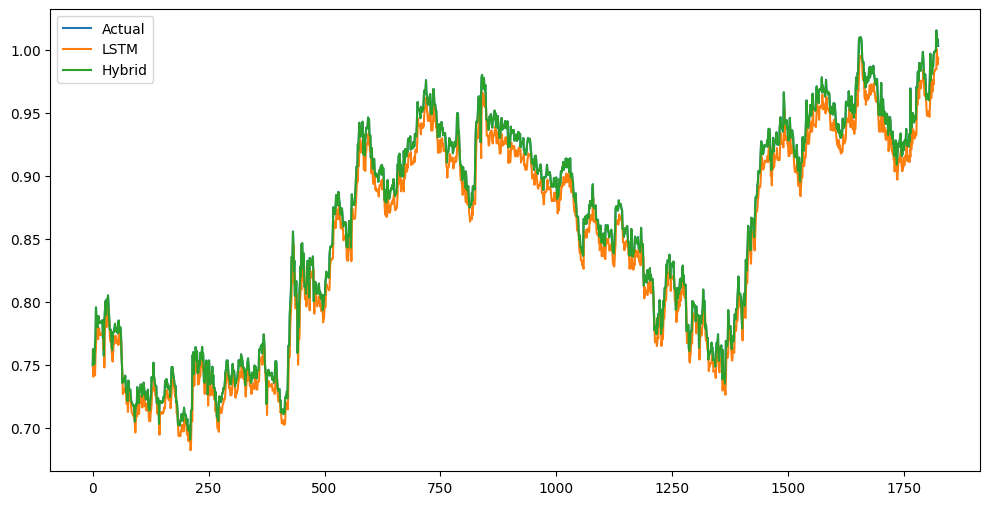

In [27]:

print("Mean Absolute Error (LSTM)  :", mae_lstm)
print("Mean Absolute Error (RF)    :", mae_RF)
print("Mean Absolute Error (Hybrid):", mae_hybrid)
print("")
print("Mean Squared Error (LSTM)  :", mse_lstm)
print("Mean Squared Error (RF)    :", mse_RF)
print("Mean Squared Error (Hybrid):", mse_hybrid)
print("")
print("Root Mean Squared Error (LSTM)  :", rmse_lstm)
print("Root Mean Squared Error (RF)    :", rmse_RF)
print("Root Mean Squared Error (Hybrid):", rmse_hybrid)
print("")
print("r2_score (LSTM)  :", r2_lstm)
print("r2_score (RF)    :", r2_RF)
print("r2_score (Hybrid):", r2_hybrid)
# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(lstm_predictions, label='LSTM')
#plt.plot(svr_predictions, label='ARIMA')
plt.plot(final_predictions, label='Hybrid')
plt.legend()
plt.show()

In [28]:
final_predictions=np.array(final_predictions)
final_predictions=pd.DataFrame(final_predictions)
final_predictions.to_csv('LSTIM_RF_EURINR.csv', index=False)